## 1. Project Overview

### Objective
Money laundering is a serious issue that affects financial institutions and governments worldwide. By analyzing large amounts of financial data, machine learning algorithms can identify patterns and anomalies that may indicate suspicious activity. In this project, we develop a model for detecting potential instances of money laundering. 

### Data
There is a lack of publicly available datasets on financial services, specially in the emerging mobile money transactions domain. Therefore, we use a data generated by PaySim (Lopez-Rojas et al. 2016), a financial simulator that simulates mobile money transactions based on an original dataset. (The data can be found in https://www.kaggle.com/datasets/ealaxi/paysim1). 

### Model & Evaluation
Our fraud detection project utilized two classifiers, Logistic Regression and XGBoost, based on earlier research by Frumerie, R. (2021). However, predicting fraudulent transactions presented two challenges: first, fraud transactions are much less frequent than non-fraud transactions, and second, failing to detect a fraud case can be much costlier than predicting a non-fraud case as fraud. Consequently, evaluating model performance solely based on accuracy can lead to misleading results. To address this, we evaluated the model using various criteria such as precision, recall, F1-score, and Detection Error Tradeoff (DET) curve. The DET curve graphically represents the False Negative Rate (FNR) as a function of the False Positive Rate (FPR). By analyzing the model's performance based on multiple criteria, we are able to make more informed decisions about its effectiveness in predicting fraudulent transactions.

### Results & Conclusion

Based on our evaluation metrics, it is clear that the XGBoost classifier outperforms the Logistic Regression model in predicting fraudulent transactions. Specifically, on the test set, the Logistic Regression classifier achieved the following performance results:

- Precision score:  0.415
- Recall score:  0.359
- F1 score:  0.385
- Accuracy score:  0.998

And XGBoost classifier's performance on test set: 
- Precision score:  0.881
- Recall score:  0.975
- F1 score:  0.926
- Accuracy score:  1.0. 

Additionally, utilizing the XGBoost classifier enables us to attain an exceptionally low False Negative Rate (less than 0.1%) without compromising the False Positive Rate, which can be minimized to as low as 1%.

## 2. Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### so that u dont have warnings
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
df = pd.read_csv("data.csv")

In [3]:
print(f'Dataset shape: {df.shape}')
df.head()

Dataset shape: (6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [5]:
non_fraud = df[df.isFraud==0]
fraud = df[df.isFraud!=0]

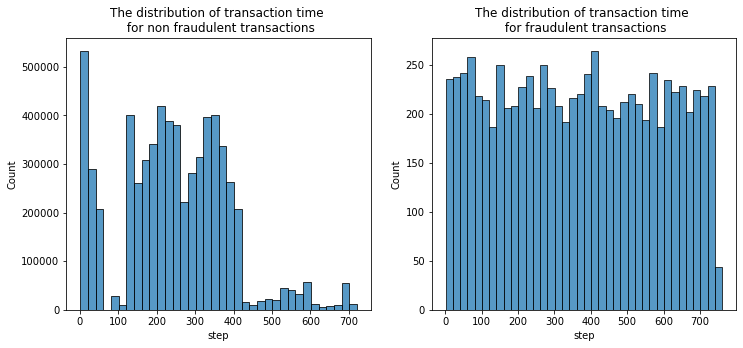

In [29]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))

sns.histplot(non_fraud["step"], binwidth=20, ax=ax1)
ax1.set_title("The distribution of transaction time \n for non fraudulent transactions")

sns.histplot(fraud["step"], binwidth=20, ax=ax2)
ax2.set_title("The distribution of transaction time \n for fraudulent transactions")

plt.show()

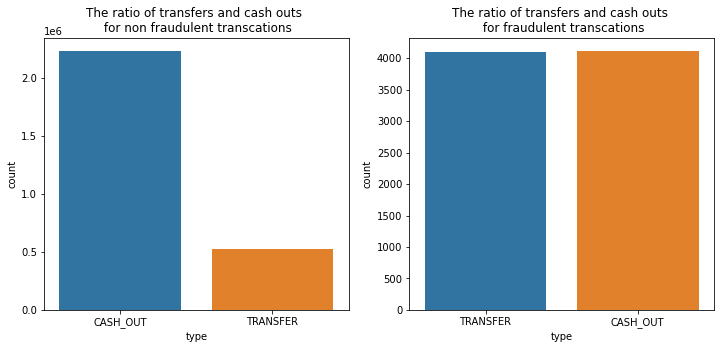

In [30]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))

non_fraud_filtered = non_fraud["type"][non_fraud["type"].isin(['TRANSFER', 'CASH_OUT'])]
sns.countplot(non_fraud_filtered, ax=ax1)
ax1.set_title("The ratio of transfers and cash outs \n for non fraudulent transcations")

sns.countplot(fraud["type"], ax=ax2)
ax2.set_title("The ratio of transfers and cash outs \n for fraudulent transcations")

plt.show()

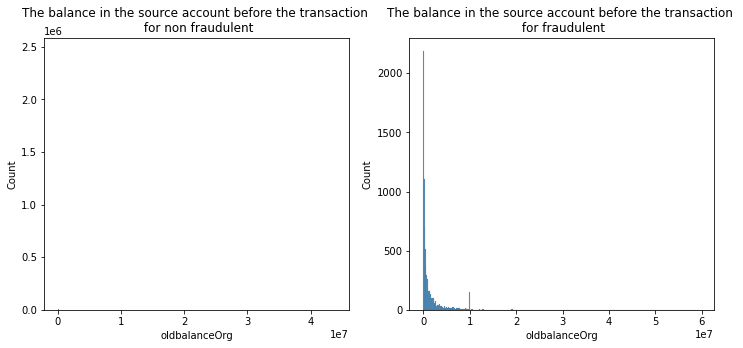

In [31]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))

sns.histplot(non_fraud["oldbalanceOrg"], ax=ax1)
ax1.set_title("The balance in the source account before the transaction \n for non fraudulent")

sns.histplot(fraud["oldbalanceOrg"], ax=ax2)
ax2.set_title("The balance in the source account before the transaction \n for fraudulent")

plt.show()

## 3. Data Preprocessing

Here, we transform the categorical text variable 'type' into numeric one-hot-encoding variables.

In [9]:
cols = ['step', 'type', 'amount','oldbalanceOrg', 'newbalanceOrig',
       'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud']

df_f = df[cols]
df_f.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,0
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,0


In [10]:
df_f.type.unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

In [11]:
col_encoded = pd.get_dummies(df_f["type"], prefix="type", drop_first=True)
df_f = pd.concat([df_f, col_encoded], axis=1)
df_f.drop("type", axis=1, inplace=True)
df_f.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0,0,0,1,0
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,0,0,1,0
2,1,181.00,181.0,0.00,0.0,0.0,1,0,0,0,0,1
3,1,181.00,181.0,0.00,21182.0,0.0,1,0,1,0,0,0
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0,0,0,1,0


## 4. Model Training

In [12]:
from sklearn.model_selection import train_test_split

X = df_f.drop("isFraud", axis=1)
y = df_f["isFraud"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=42)

In [13]:
import xgboost as xgb
from xgboost import XGBClassifier

xgb_clf = XGBClassifier()
xgb_clf = xgb_clf.fit(X_train, y_train)

In [81]:
pred_prob =xgb_clf.predict_proba(X_train)

In [82]:
prediction = xgb_clf.predict(X_train)

In [68]:
from sklearn.linear_model import LogisticRegression

In [73]:
log_clf = LogisticRegression(random_state=0).fit(X_train, y_train)
log_prediction = xgb_clf.predict(X_train)

## 5. Results

In [83]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


print("Precision score: ", round(precision_score(prediction, y_train), 3)) #TP/(FP+TP)
print("Recall score: ", round(recall_score(prediction, y_train), 3)) #TP/(FN+TP)
print("F1 score: ", round(f1_score(prediction, y_train), 3)) #2* Precision Score * Recall Score/ (Precision Score + Recall Score)
print("Accuracy score: ", round(accuracy_score(prediction, y_train), 3)) #(TP + TN)/ (TP + FN + TN + FP)

Precision score:  0.916
Recall score:  0.99
F1 score:  0.952
Accuracy score:  1.0


XGBoost outcome on training data 

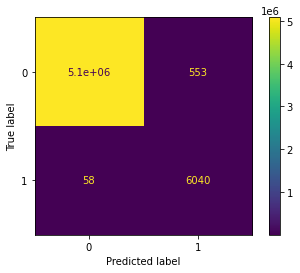

In [84]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(prediction, y_train)
cm_display = ConfusionMatrixDisplay(cm).plot()

Logistic Regression outcome on training data

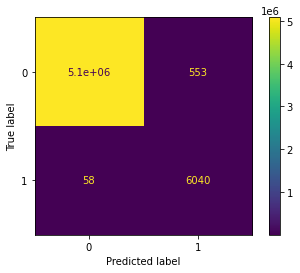

In [85]:
cm = confusion_matrix(log_prediction, y_train)
cm_display = ConfusionMatrixDisplay(cm).plot()

XGBoost outcome on test data

In [86]:
pred_prob =xgb_clf.predict_proba(X_test)
prediction = xgb_clf.predict(X_test)

print("Precision score: ", round(precision_score(prediction, y_test), 3)) #TP/(FP+TP)
print("Recall score: ", round(recall_score(prediction, y_test), 3)) #TP/(FN+TP)
print("F1 score: ", round(f1_score(prediction, y_test), 3)) #2* Precision Score * Recall Score/ (Precision Score + Recall Score)
print("Accuracy score: ", round(accuracy_score(prediction, y_test), 3)) #(TP + TN)/ (TP + FN + TN + FP)

Precision score:  0.881
Recall score:  0.975
F1 score:  0.926
Accuracy score:  1.0


Logistic Regression outcome on test data

In [87]:
pred_prob =log_clf.predict_proba(X_test)
prediction = log_clf.predict(X_test)

print("Precision score: ", round(precision_score(prediction, y_test), 3)) #TP/(FP+TP)
print("Recall score: ", round(recall_score(prediction, y_test), 3)) #TP/(FN+TP)
print("F1 score: ", round(f1_score(prediction, y_test), 3)) #2* Precision Score * Recall Score/ (Precision Score + Recall Score)
print("Accuracy score: ", round(accuracy_score(prediction, y_test), 3)) #(TP + TN)/ (TP + FN + TN + FP)

Precision score:  0.415
Recall score:  0.359
F1 score:  0.385
Accuracy score:  0.998


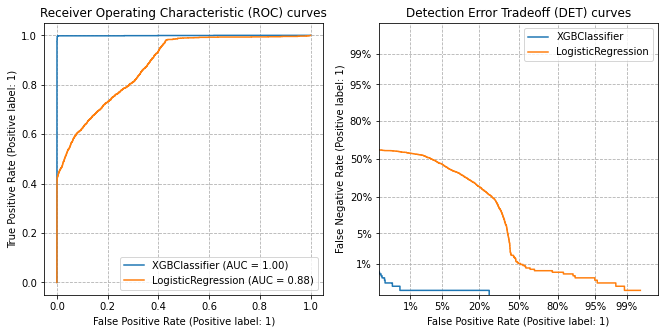

In [88]:
import matplotlib.pyplot as plt
from sklearn.metrics import DetCurveDisplay, RocCurveDisplay

fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))


RocCurveDisplay.from_estimator(xgb_clf, X_test, y_test, ax=ax_roc)
RocCurveDisplay.from_estimator(log_clf, X_test, y_test, ax=ax_roc)

DetCurveDisplay.from_estimator(xgb_clf, X_test, y_test, ax=ax_det)
DetCurveDisplay.from_estimator(log_clf, X_test, y_test, ax=ax_det)

ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
ax_det.set_title("Detection Error Tradeoff (DET) curves")

ax_roc.grid(linestyle="--")
ax_det.grid(linestyle="--")

plt.legend()
plt.show()

## 7. References

Frumerie, R. (2021). Money Laundering Detection using Tree Boosting and Graph Learning Algorithms.

Lopez-Rojas, E., Elmir, A., & Axelsson, S. (2016). PaySim: A financial mobile money simulator for fraud detection. In 28th European Modeling and Simulation Symposium, EMSS, Larnaca (pp. 249-255). Dime University of Genoa.(https://kth.diva-portal.org/smash/get/diva2:1663255/FULLTEXT01.pdf)